# Sekvencijalno kvadratno programiranje (SQP ) 

## Kvadratno programiranje QP

Optimizacioni problem kod kojeg je funkcija cilja kvadratna i ograničenja su linearna, nazivamo kvadratnim programom. 
Kvadratno programiranje može se zapisati kao:
min  f(x),
uz ograničenja : hi(x) = 0, i ∈ I
gi(x) ≥ 0, i ∈ E.

Iz izraza se može videti kako je cilj kvadratnog programiranja pronaći tačku x
koja minimizuje ciljnu funkciju f(x) i ujedno zadovoljava sva ograničenja g(x) i h(x).

Nužni uslove da neka tačka predstavlja lokalni minimum
kvadratnog programa je da ispunjava Karush-Kuhn-Tuckerovi uslove optimalnosti (KKT).

Ako je tačka x* lokalni minimum kvadratnog problema onda postoje jedinstveni Lagranžovi multiplikatori λ∗ ∈ Rp i µ∗ ∈ Rq takvi da zadovoljavaju ograničenja:


    (KKT1) (∇f)(x∗) − (∇h)(x∗)λ∗ − (∇g)(x∗)µ∗ = 0
    (KKT2) h(x∗) = 0
    (KKT3) g(x∗) ≥ 0
    (KKT4) µ∗ ≥ 0
    (KKT5) gT(x∗)µ∗ = 0

Primetimo kako je cilj zapisati gradijent ciljne funkcije kao linearnu kombinaciju gradijenata ograničenja.


    
Potrebno je naglasiti da KKT uslovi predstavljaju nužne, ali ne i dovoljne uslove da tačka x∗ predstavlja minimum optimizacijskog problema. No ako je ciljna funkcija konveksna i ako su ograničenja linearna, onda KKT uslovi predstavljaju i dovoljne uslove.

Metoda kojom možemo rešiti kvadratni program gde je ciljna funkcija kvadratna, a ograničenja su linearna nazivamo metoda aktivnih ograničenja.
Metoda aktivnih ograničenja obično započinje s nekom regularnom tackom i osigurava da su sve tacke u sljedećim iteracijama regularne. Ova metoda pronalazi pomak iz trenutne tacke u sljedeću tačku na način da reši kvadratni program koji se sastoji od svih ograničenja jednakosti i nekih ograničenja nejednakosti koja se
tretiraju kao ograničenja jednakosti (odnosno, kažemo da su ta ograničenja aktivna u toj točki).


## Sekvencijalno kvadratno programiranje

Metoda koja može raditi s proizvoljno nelinearnim funkcijama cilja i s proizvoljno nelinearnim ograničenjima nazivamo Sekvencijalno kvadratno programiranje (SQP)
 
Cilj je u svakoj iteraciji nelinearni optimizacioni problem aproksimirati kvadratnim programom i rešiti ga primenjujući metodu aktivnih ograničenja.

Ideja SQP jeste modelovati nelinearni problem s trenutnom tačkom xk kao kvadratni program koji se minimizuje kako bi se pronašla tačka xk+1 za sledeću iteraciju.
Kako kvadratno programiranje radi isključivo s kvadratnim funkcijama cilja i linearnim ograničenjima, to znači da ćemo morati nelinearnu funkciju cilja aproksimirati kvadratnom funkcijom, a ograničenja linearnim funkcijama.

In [395]:
import numpy as np
import cvxopt as cx
import matplotlib.pyplot as plt
from scipy import optimize as opt

In [396]:
# preporucene vrednisti parametara
eta = 1e-8
gamma = 0.5
beta_eps = 0.5
beta_rho = 0.5
beta_theta = 0.8
nu = 10
xi_s = 1000
xi_y = 1000
xi_sy = 1e-6

In [397]:
def SQP(f, gI, gE, x0 = None, tol = 1e-8, max_iter = 100):

    eps = 0.1 # proizvoljna okolina
    rho = 0.1
    mi = 1 - rho # parametar kazne
    theta = 0.1
    
    dim = f.dim
    
    nI = 1 
    nE = 1 
    
    p0 = 2                             
    pI_ = [3] 
    pE_ = [4]
        
    pI = np.array([3])
    pE = np.array([4])
    
    # Inicijalizacija potproblema
    SP = Subproblem(dim, nI, nE, p0, pI, pE)
    
    x_k = np.zeros(dim) if x0 is None else x0.copy()
        
    iter_H = 10
    E_k = np.inf
    
    x_hist = [x_k]
    x_kmin1 = None
    g_kmin1 = None
    s_hist = np.zeros((dim, iter_H))
    y_hist = np.zeros((dim, iter_H))
    
    H = np.eye(dim)
    
    status = 'nije optimalno'
    step = np.nan
    
    
    ##############################################
    # Pocetak iteracija
    ##############################################
    
    for iter_k in range(max_iter):
        
        if E_k <= tol:
            status = 'optimalno'
            break

        # Tabeliramo funkcije u tackama iz epsilon okoline tacke x_k     
        B_f = sample_points(x_k, eps, p0)
        B_f = np.vstack((x_k, B_f))
        
        B_gI = []
        B_j = sample_points(x_k, eps, pI_[0])
        B_j = np.vstack((x_k, B_j))
        B_gI.append(B_j)
            
        B_gE = []
        B_j = sample_points(x_k, eps, pE_[0])
        B_j = np.vstack((x_k, B_j))
        B_gE.append(B_j)
   
        # Izracunavamo gradijente  
        D_f = compute_gradients(f, B_f)[0] 
        D_gI = compute_gradients(gI[0], B_gI[0])   
        D_gE = compute_gradients(gE[0], B_gE[0])

        # Vrednost ciljane funkcije f u tacki x_k 
        f_k = f.eval(x_k)
        
        # Vrednost funkcija ogranicenja u tacki x_k
        gI_k = np.hstack([gI[0].eval(x_k)]) if nI > 0 else np.array([])
        gE_k = np.hstack([gE[0].eval(x_k)]) if nE > 0 else np.array([])
       
        
        ##############################################
        # POTPROBLEM
        ##############################################
        
        # Resavamo potproblem
        SP.update(H, rho , D_f, D_gI, D_gE, f_k, gI_k, gE_k)
        SP.solve()
        
        d_k = SP.d.copy() 
        
        g_k = np.dot(SP.lambda_f, D_f) + np.dot(SP.lambda_gI[0], D_gI[0]) + np.dot(SP.lambda_gE[0], D_gE[0])
  
        v_k = (np.maximum(gI_k, 0) + np.abs(gE_k))[0]

        phi_k = f_k + mi*v_k  
        delta_q = phi_k - q_rho(d_k, rho , H, f_k, gI_k, gE_k, D_f, D_gI, D_gE) 
 
        new_E_k = stop_criterion(gI, gE, g_k, SP, gI_k, gE_k, B_gI, B_gE, nI, nE, pI, pE)
        E_k = min(E_k, new_E_k)
        
        ##############################################
        # KORAK
        ##############################################
        
        step = delta_q > tol
        if step:
            alpha = 1.
            phi_new = phi_mi(x_k + alpha*d_k, f, gI, gE, mi) # kaznena funkcija
            
            # Armijo pravilo sa uslovima ogranicenja
            while phi_new > phi_k - eta*alpha*delta_q:                
                alpha *= gamma
                phi_new = phi_mi(x_k + alpha*d_k, f, gI, gE, mi)
              
            # Racunanje  Hesijana                
            if x_kmin1 is not None:
                s_k = x_k - x_kmin1
                s_hist = np.roll(s_hist, 1, axis = 1)
                s_hist[:,0] = s_k
                
                y_k = g_k - g_kmin1
                y_hist = np.roll(y_hist, 1, axis = 1)
                y_hist[:,0] = y_k
                
                B_k = np.eye(dim)
                
                # Aproksimacija Hesijana funkcije f metodom BFGS
                for l in np.arange(iter_H):
                    sl = s_hist[:,l]
                    yl = y_hist[:,l]
                    
                    cond = (np.linalg.norm(sl) <= xi_s*eps) and (np.linalg.norm(yl) <= xi_y*eps) and (np.inner(sl,yl) >= xi_sy*eps**2)
                    
                    if cond:
                        Bs = np.dot(B_k, sl)
                        B_k = B_k + np.outer(yl, yl)/(np.dot(yl, sl) +  1e-16) - np.outer(Bs, Bs)/(np.dot(sl, Bs) + 1e-16)
                
                H = B_k.copy()

            x_kmin1 = x_k.copy()
            g_kmin1 = g_k.copy()
            
            x_k = x_k + alpha*d_k
                    
        else:
            if v_k <= theta:
                theta *= beta_theta
            else:
                rho *= beta_rho
                mi = 1 - rho
            
            eps *= beta_eps
        
        
        x_hist.append(x_k)    
            
    ##############################################

    x_hist = np.vstack(x_hist)
    
    if E_k > tol:
        status = 'maximalan broj iteracija'
    return x_k, x_hist, SP, iter_k


In [398]:
def sample_points(x, eps, N):
    # proizvoljnih N tacaka iz date okoline x
    
    dim = len(x)
    U = np.random.randn(N, dim)
    norm_U = np.linalg.norm(U, axis = 1)
    R = np.random.rand(N)**(1/dim)    
    Z = eps * (R/norm_U)[:,np.newaxis] * U
    
    return x + Z

In [399]:
def q_rho(d, rho, H, f_k, gI_k, gE_k, D_f, D_gI, D_gE):
    # f(xk) + grad_f*d + max{gI(xk) + grad_gI*d, 0} + max|gE(xk) + grad_gE*d| 
    # Usmerena derivacija merne funkcije u smeru d
    
    t_f = f_k + np.max(np.dot(D_f, d))

    t_gI = np.maximum(gI_k[0] + np.dot(D_gI[0], d), 0).max()
   
    t_gE = np.abs(gE_k[0] + np.dot(D_gE[0],d)).max()
       
    return t_f + (1-rho)*(t_gI + t_gE)

In [400]:
def phi_mi(x, f, gI, gE, mi):
    # phi_mi(x) = f(x) + mi*V(x)
    # Koristeći principe kaznenih funkcija, 
    # merna funkcija uzima u obzir i ograničenja 
    # i ciljnu funkciju prilikom računanja dužine koraka.
    # mi je parametar kazne, a V je maksimalno prekoračenje ograničenja. 
    # V je definisano na sledeći način: max{ max{gI(x), 0}, |gE(x)| }
    # Parametar kazne mi se uvodi zbog dodatne kontrole nad funkcijom phi_mi
    
    f_x = f.eval(x)

    gI_x = np.maximum(gI[0].eval(x), 0) if len(gI) > 0 else 0
    
    gE_x = np.abs(gE[0].eval(x)) if len(gE) > 0 else 0
        
    return f_x + mi*np.maximum(gI_x, gE_x)

In [401]:
def stop_criterion(gI, gE, g_k, SP, gI_k, gE_k, B_gI, B_gE, nI_, nE_, pI, pE):
    # max{||g_k||, gI_k, |gE_k|, lambda*gI, lambda*gE}
    # Kriterijum zaustavljanja

    val1 = np.linalg.norm(g_k, np.inf)
    val2 = np.max(gI_k, initial = -np.inf)
    val3 = np.max(np.abs(gE_k), initial = -np.inf)
    
    gI_vals = fun_eval(gI[0], B_gI[0])
    
    val4 = -np.inf
    val4 = np.maximum(val4, np.max(SP.lambda_gI[0] * gI_vals[0]))
    
    gE_vals = fun_eval(gE[0], B_gE[0])
    
    val5 = -np.inf
    val5 = np.maximum(val5, np.max(SP.lambda_gE[0] * gE_vals[0]))
    
    return np.max(np.array([val1, val2, val3, val4, val5]))

In [402]:
def fun_eval(fun, X):
    # Vrednost funkcije fun u tacki X

    (N, _) = X.shape
    D = np.zeros((N, 1))
    for i in np.arange(N):
        D[i,:,] = fun.eval(X[i,:])
    
    return [D[:,0]]

In [403]:
def compute_gradients(fun, X):
    # Racunanje gradijenta funkcije fun u tacki X

    (N, dim) = X.shape
    D = np.zeros((N, 1, dim))
    for i in np.arange(N):
        D[i,:,:] = fun.grad(X[i,:])
    
    D_list = list()
    D_list.append(D[:,0,:])
    
    return D_list 

In [404]:
class Subproblem:
    def __init__(self, dim, nI, nE, p0, pI, pE):
        self.dim = dim
        self.nI = nI
        self.nE = nE
        self.p0 = p0
        self.pI = pI
        self.pE = pE
        
        self.P, self.q, self.inG, self.inh, self.nonnegG, self.nonnegh = self.initialize()
        
    
    def solve(self):
        """    
        Ovo resava kvadratni program
        u svakoj iteraciji pozivamo self.update pre resavanja 
        kako bismo imali adekvatne podatke potproblema
        self.d: array
            search direction
            
        self.lambda_f: array
            KKT uslovi za ciljanu funkciju.
            
        self.lambda_gE: list
            KKT uslovi za jednakosna ogranicenja. 
        
        self.lambda_gI: list
            KKT uslovi za nejednakosna ogranicenja.    
        """
        cx.solvers.options['show_progress'] = False
        
        iG = np.vstack((self.inG, self.nonnegG))
        ih = np.hstack((self.inh, self.nonnegh))
        
        qp = cx.solvers.qp(P = cx.matrix(self.P), q = cx.matrix(self.q), G = cx.matrix(iG), h = cx.matrix(ih))
        
        self.status = qp["status"]
        self.cvx_sol_x = np.array(qp['x']).squeeze()
        
        self.d = self.cvx_sol_x[:self.dim]
        self.z = self.cvx_sol_x[self.dim]

        self.rI = self.cvx_sol_x[self.dim +1          : self.dim +1 +self.nI]
        self.rE = self.cvx_sol_x[self.dim +1 + self.nI : ]
        
        
        self.cvx_sol_z = np.array(qp['z']).squeeze()
        lambda_f = self.cvx_sol_z[:self.p0+1]
        
        lambda_gI = list()
        for j in np.arange(self.nI):
            start_ix = self.p0+1+(1+self.pI)[:j].sum()
            lambda_gI.append( self.cvx_sol_z[start_ix : start_ix + 1+self.pI[j]]  )
        
        lambda_gE = list()
        for j in np.arange(self.nE):
            start_ix = self.p0+1+(1+self.pI).sum()+(1+self.pE)[:j].sum()
            
            vec1 = self.cvx_sol_z[start_ix : start_ix + 1+self.pE[j]]
            vec2 = self.cvx_sol_z[start_ix+(1+self.pE).sum() : start_ix + (1+self.pE).sum() + 1+self.pE[j]]
            
            lambda_gE.append(vec1-vec2)
     
        self.lambda_f = lambda_f.copy()
        self.lambda_gI = lambda_gI.copy()
        self.lambda_gE = lambda_gE.copy()
        
        return 
        
        
    def initialize(self):
        """
        kvadratni potporblem koji resavamo u svakoj iteraciji je u obliku:
        min_y 1/2* yPy + q*y,  Gy <= h
        
        """
        
        dimQP = self.dim+1 + self.nI + self.nE
        
        P = np.zeros((dimQP, dimQP))
        q = np.zeros(dimQP)
        
        inG = np.zeros((1 + self.p0+np.sum(1+self.pI) + 2*np.sum(1+self.pE), dimQP))
        inh = np.zeros( 1 + self.p0+np.sum(1+self.pI) + 2*np.sum(1+self.pE))
        
        inG[:self.p0+1, self.dim] = -1
        
        for j in range(self.nI):
            inG[self.p0+1+(1+self.pI)[:j].sum()                                     :  self.p0+1+(1+self.pI)[:j].sum()                                      + self.pI[j]+1, self.dim+1+j]         = -1
            
        for j in range(self.nE):
            inG[self.p0+1+(1+self.pI).sum()+(1+self.pE)[:j].sum()                   :  self.p0+1+(1+self.pI).sum()+(1+self.pE)[:j].sum()                    + self.pE[j]+1, self.dim+1+self.nI+j] = -1
            inG[self.p0+1+(1+self.pI).sum()+(1+self.pE).sum()+(1+self.pE)[:j].sum() :  self.p0+1+(1+self.pI).sum()+(1+self.pE).sum()+(1+self.pE)[:j].sum()  + self.pE[j]+1, self.dim+1+self.nI+j] = -1
            
        nonnegG = np.hstack((np.zeros((self.nI + self.nE, self.dim + 1)), -np.eye(self.nI + self.nE)))
        nonnegh = np.zeros(self.nI + self.nE)
     
        return P,q,inG,inh,nonnegG,nonnegh


    def update(self, H, rho, D_f, D_gI, D_gE, f_k, gI_k, gE_k):
        """

        H : array
            aproksimacija Hesiana 
        rho : float
            parametar
        D_f : array
            gradijent funkcije f u tacki
        D_gI : list
            gradijent nejednakosnih ogranicenja
        D_gE : list
            gradijent jednakosnih ogranicenja
        f_k : float
            vrednost funkcije f u x_k.
        gI_k : array
            vrednost funkcije nejednakosnih ogranicenja u x_k
        gE_k : array
            vrednost funkcije jednakosnih ogranicenja u x_k

        """
        self.P[:self.dim, :self.dim] = H
        self.q = np.hstack((np.zeros(self.dim), rho, np.ones(self.nI), np.ones(self.nE))) 
        
        self.inG[:self.p0+1, :self.dim] =  D_f
        self.inh[:self.p0+1]            = -f_k
        
        for j in range(self.nI):
            self.inG[self.p0+1+(1+self.pI)[:j].sum()        :  self.p0+1+(1+self.pI)[:j].sum()        + self.pI[j]+1, :self.dim]    =  D_gI[j]
            self.inh[self.p0+1+(1+self.pI)[:j].sum()        :  self.p0+1+(1+self.pI)[:j].sum()        + self.pI[j]+1]               = -gI_k[j] 
            
        for j in range(self.nE):
            self.inG[self.p0+1+(1+self.pI).sum()+(1+self.pE)[:j].sum()                   :  self.p0+1+(1+self.pI).sum()+(1+self.pE)[:j].sum()                   + self.pE[j]+1, :self.dim]  =  D_gE[j]
            self.inG[self.p0+1+(1+self.pI).sum()+(1+self.pE).sum()+(1+self.pE)[:j].sum() :  self.p0+1+(1+self.pI).sum()+(1+self.pE).sum()+(1+self.pE)[:j].sum() + self.pE[j]+1, :self.dim]  = -D_gE[j]
            
            self.inh[self.p0+1+(1+self.pI).sum()+(1+self.pE)[:j].sum()                   :  self.p0+1+(1+self.pI).sum()+(1+self.pE)[:j].sum()                   + self.pE[j]+1]             = -gE_k[j]
            self.inh[self.p0+1+(1+self.pI).sum()+(1+self.pE).sum()+(1+self.pE)[:j].sum() :  self.p0+1+(1+self.pI).sum()+(1+self.pE).sum()+(1+self.pE)[:j].sum() + self.pE[j]+1]             =  gE_k[j]
            
       
        return        
    


In [405]:
class f_:
    def __init__(self):
        self.name = 'f_'
        self.dim = 2
        
    def eval(self, x):    
        return (x[0] - 2)**2 + (x[1] - 1)**2
    
    def grad(self, x):
        return np.array([2*(x[0]-2), 2*(x[1]-1)])
    
class h_linear:
    def __init__(self):
        self.name = ' h_linear'
        self.dim = 2
        
    def eval(self, x):    
        return 3*x[0] - x[1]
    
    def grad(self, x):
        return np.array([3, -1])

class g_linear:
    def __init__(self):
        self.name = 'g_linear'
        self.dim = 2
        
    def eval(self, x):    
        return 2*x[0] - 3*x[1] + 1 
    
    def grad(self, x):
        return  np.array([2, -3])

In [406]:

    
def fun(x):
    return (x[0] - 2)**2 + (x[1] - 1)**2


constraints = [
    {
        'type': 'eq',
        'fun': lambda x: np.array([3*x[0] - x[1]]),
        'jac': lambda x: np.array([3, -1]) 
    },
    {
        'type': 'ineq',
        'fun': lambda x: np.array([2*x[0] - 3*x[1] + 1]),
        'jac': lambda x: np.array([2, -3])
    }
]

def test_f():
    gI = [g_linear()]
    gE = [h_linear()]
    xstar = np.array([0, 0])
    x, x_hist, _, iter_k = SQP(f_(), gI, gE, x0 = xstar, tol = 1e-6, max_iter = 300)
    z = opt.minimize(fun, (0, 0), constraints = constraints, tol = 1e-6)
    
    return x, list(z.x), iter_k


In [407]:
# testiramo funkciju SQP na jednostavnom primeru sa lineranim ogranicenjima
# ispisujemo u kojoj tacki je dostignut minimum i vrednost funkcije u tom minimumu
# kao i koliko iteracija je potrebno za pronalazak minimuma

r1, r2, iter_k = test_f()
print(r1, f_().eval(r1), iter_k)
print(r2, f_().eval(r2))

[0.49996589 1.49989768] 2.5000000156224838 101
[0.14285714285714327, 0.4285714285714299] 3.77551020408163


In [408]:
import matplotlib.colors as mcolors

In [409]:

colors = mcolors.TABLEAU_COLORS
colours = []
for c in colors:
    colours.append(c[4:])

(-2, 2)

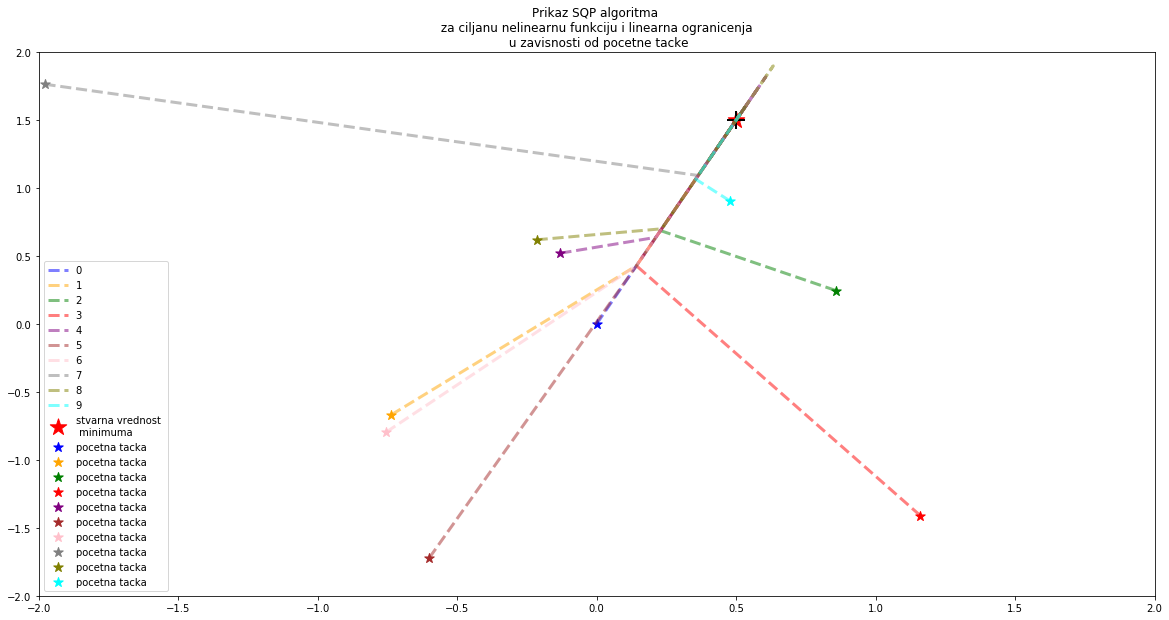

In [410]:
# Na jendostavnom primeru nelinerne funkcije sa lineranim ogranicenjima, 
# mozemo da analiziramo kako pocetna tacka utice na brzinu dostizanja trazenog minimuma
# u ovom primeru smo iscrtali 10 tacaka i putanje kretanja do minimuma

f = f_()
gI = [g_linear()]
gE = [h_linear()]

xstar = np.array([0, 0])

X, Y = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))

fig, ax = plt.subplots(figsize=(20, 10))

# Iscrtavamo stvarnu vrednost minimuma 
ax.scatter(0.5, 1.5, marker = "*", s = 300, c = "red", alpha = 1, label = 'stvarna vrednost \n minimuma' ) 

x0 = xstar
for i in range(10): 
    x_k, x_hist, _, _ = SQP(f, gI, gE, x0, tol = 1e-6, max_iter = 100)
    ax.plot(x_hist[:,0], x_hist[:,1], c = colours[i], lw = 3, ls = '--', alpha = 0.5, label = i)
    ax.scatter(x0[0], x0[1], marker = "*", s = 100, c = colours[i], alpha = 1, label = 'pocetna tacka')
    ax.scatter(x_k[0], x_k[1], marker = "+", s = 300, c = "black", alpha = 1)
    x0 = np.random.randn(2)

ax.legend(loc = 'lower left')
plt.title("Prikaz SQP algoritma \n za ciljanu nelinearnu funkciju i linearna ogranicenja \n u zavisnosti od pocetne tacke")
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

In [411]:
class F:
    """
    
    """
    def __init__(self):
        self.name = 'F'
        self.dim = 2
        
    def eval(self, x):    
        return x[0]**4 - 2*x[0]**2*x[1] + x[0]**2 + x[0]*x[1]**2 - 2*x[0] + 4    
    
    def grad(self, x):
        return np.array([4*x[0]**3 - 4*x[0]*x[1] + 2*x[0] + x[1]**2 - 2, -2*x[0]**2 + 2*x[0]*x[1] ])   

class H:
    def __init__(self):
        self.name = 'jednakosna ogranicenja'
        self.dim = 2

    def eval(self, x):    
        return x[0]**2 + x[1]**2 -2 
    
    def grad(self, x):
        return np.array([2*x[0], 2*x[1]]) 
    

class G:
    def __init__(self):
        self.name = 'nejednakosna ogranicenja'
        self.dim = 2
        
    def eval(self, x):    
        return 0.25*x[0]**2 + 0.75*x[1]**2 - 1
    
    def grad(self, x):
        return  np.array([-0.5*x[0], -1.5*x[1]])
    
def fun(x):
    return x[0]**4 - 2*x[0]**2*x[1] + x[0]**2 + x[0]*x[1]**2 - 2*x[0] + 4 

constraints = [
    {
        'type': 'eq',
        'fun': lambda x: np.array([x[0]**2 + x[1]**2 -2 ]),
        'jac': lambda x: np.array([2*x[0], 2*x[1]])
    },
    {
        'type': 'ineq',
        'fun': lambda x: np.array([0.25*x[0]**2 + 0.75*x[1]**2 - 1]),
        'jac': lambda x: np.array([-0.5*x[0], -1.5*x[1]])
    }
]

def test_F():
    gI = [G()]
    gE = [H()]
    xstar = np.array([1.5, 0.5])
    x, x_hist, _ , iter_k = SQP(F(), gI, gE, x0 = xstar, tol = 0.000001, max_iter = 300)
    z = opt.minimize(fun, (1.5, 0.5), constraints = constraints, tol = 0.000001)

    return x, list(z.x), iter_k


In [412]:
# testiramo funkciju SQP na primeru sa nelineranim ogranicenjima
# ispisujemo u kojoj tacki je dostignut minimum i vrednost funkcije u tom minimumu
# kao i koliko iteracija je potrebno za pronalazak minimuma

r, R, iter_k = test_F()
print(r,F().eval(r), iter_k )
print(R,F().eval(R) )

[0.79346619 1.20929555] 3.07668221206648 299
[1.4969577198611188, 0.4891436769054905] 6.43445844975933


(0, 1.5)

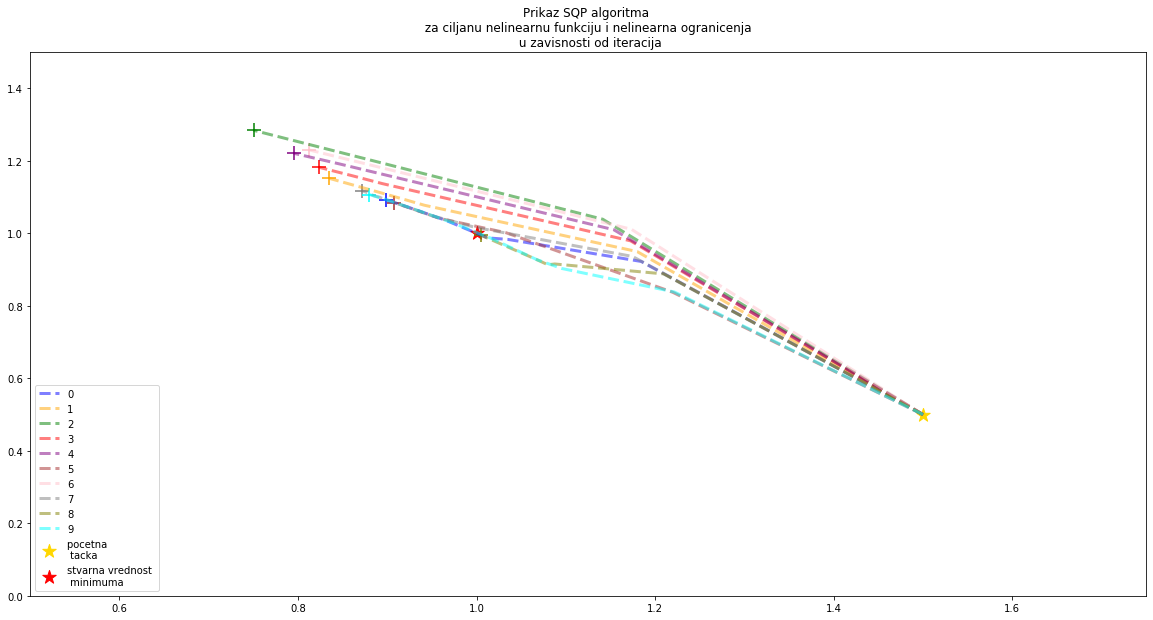

In [413]:
# Na primeru nelinerne funkcije sa nelinearnim ogranicenjima, 
# mozemo da analiziramo kako broj iteracija utice na preciznost

f = F()
gI = [G()]
gE = [H()]

xstar = np.array([1.5, 0.5])

X, Y = np.meshgrid(np.linspace(0.8,1.5,100), np.linspace(0.2,1.2,100))

fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(xstar[0], xstar[1], marker = "*", s = 200, c = "gold", alpha = 1, label = 'pocetna \n tacka')   
ax.scatter(1, 1, marker = "*", s = 200, c = "red", alpha = 1, label = 'stvarna vrednost \n minimuma') 

for i in range(10):
    x0 = xstar
    x_k, x_hist, _, _ = SQP(f, gI, gE, x0, tol = 1e-6, max_iter = 100+100*i)
    ax.plot(x_hist[:,0], x_hist[:,1], c = colours[i], lw = 3, ls = '--', alpha = 0.5, label=i)
    ax.scatter(x_k[0], x_k[1], marker = "+", s = 200, c = colours[i], alpha = 1)
ax.legend(loc = 'lower left')
plt.title("Prikaz SQP algoritma \n za ciljanu nelinearnu funkciju i nelinearna ogranicenja \n u zavisnosti od iteracija")
ax.set_xlim(0.5,1.75)
ax.set_ylim(0,1.5)

Bibliografija:

    [1] Marko Đurašević, Kvadratično i sekvencijalno kvadratično programiranje
    [2] Chapter 4, Sequential Quadratic Programming
    [3] Dalibor Spasić, Optimizacija u programskom paketu MATHEMATICA i primene